In [86]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer, load_wine,load_digits
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [87]:
data = load_digits()

In [88]:
input_ = data.data
output_ = data.target

In [89]:
pd.DataFrame(output_).value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(444)
if device == 'cuda':
    torch.cuda.manual_seed_all(444)

In [91]:
len(input_)

1797

In [92]:
x_train, x_test, y_train, y_test = train_test_split(input_, output_, test_size = 0.3,
                                                   random_state= 44, stratify=data.target,
                                                   shuffle = True)


# 전처리
scaler = StandardScaler()
scaler.fit(x_train) # scaling의 기준은 train data가 되어야 한다.

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)



In [93]:
type(input_)

numpy.ndarray

In [94]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device) # 범주형 변수는 long tensor 형에 넣어주어야 함.
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [95]:
print(x_train[0])
print(y_train[0])

tensor([ 0.0000, -0.3422, -1.0883, -0.9071,  0.2616, -1.0165, -0.4055, -0.1283,
        -0.0657, -0.6260, -1.8989,  0.5122, -0.8992, -1.3375, -0.4991, -0.1320,
        -0.0282, -0.7223, -0.6714,  0.8649, -1.1559, -1.2475, -0.5516, -0.1038,
        -0.0282, -0.7874, -0.1730,  0.6910, -0.3250, -0.9309, -0.6222, -0.0399,
         0.0000, -0.6780,  0.8389,  1.0998,  0.4571,  0.9045,  0.3328,  0.0000,
        -0.0489, -0.5294,  0.6252,  0.1166, -0.9032, -0.9095,  2.2006, -0.0949,
        -0.0426, -0.4090, -0.0935,  0.2918, -0.8380,  0.5516,  1.5141, -0.2006,
        -0.0282, -0.3021, -0.8937, -0.2499,  0.0346, -0.4551, -0.4970, -0.1888],
       device='cuda:0')
tensor(6, device='cuda:0')


In [96]:
# Custom Dataset 객체를 만들기 위해서는.. 3가지가 필요하다.
    # __init__, __len__, __getitem__; 호출할때마다 x,y를 slicing을 통해서 불러올 수 있다. (짝지어서)
    # 이를 DataLoader 객체에 넣어서 batch_size 별로 빼낼 수 있다.

In [97]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    
    def __init__(self):
        self.x_data = x_train
        self.y_data = [[y] for y in y_train]
        # 데이터 셋 전처리는 미리 위에서 진행함 
        # (X,y가 텐서 형태로 들어가서 sklearn이랑 연동되는지, 오류가 날지 잘 모름.)
        
    def __len__(self):
        return len(self.x_data)
    # 데이터 셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx]).to(device)
        y = torch.LongTensor(self.y_data[idx]).to(device)
        # 데이터 셋을 slicing을 통해서 가져오게 할 수 있음.
        
        return x,y

In [98]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size = batch_size)

In [99]:
y_train.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [110]:
model = nn.Sequential(nn.Linear(64, 512),
                     nn.ReLU(),
                     nn.Linear(512, 256),
                     nn.ReLU(),
                     nn.Linear(256,128),
                    nn.ReLU(),
                     nn.Linear(128,64),
                    nn.ReLU(),
                     nn.Linear(64,10),
                     nn.Softmax()).to(device)

In [226]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 512),
                                  nn.ReLU()
                                  )
        self.layer2 = nn.Sequential(nn.Linear(512, 256),
                                  nn.ReLU()
                                  )
        self.layer3 = nn.Sequential(nn.Linear(256,128),
                                  nn.ReLU()
                                  )
        self.layer4 = nn.Sequential(nn.Linear(128,64),
                                  nn.ReLU()
                                   )
                                    
        self.layer5 = nn.Sequential(nn.Linear(64, 10),
                                  nn.Softmax()
                                  )
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)        
        return output
    

In [227]:
def init_weights(layer):
    if isinstance(layer, nn.Linear): # 존재시
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)
        
        
        

In [228]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [229]:
loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [230]:
losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    hypothesis = model(x_train)
    
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())
    
    if epoch % 10 == 0:
        print(epoch, cost.item())

C:\Users\USER\Anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.306436538696289
10 1.6321520805358887
20 1.5863136053085327
30 1.5815954208374023
40 1.5800851583480835
50 1.5797655582427979
60 1.579595923423767
70 1.5794721841812134
80 1.5771812200546265
90 1.5788310766220093
100 1.5784028768539429
110 1.5775946378707886
120 1.577304720878601
130 1.5763479471206665
140 1.5766716003417969
150 1.5760215520858765
160 1.575722098350525
170 1.5756648778915405
180 1.5755767822265625
190 1.5754884481430054
200 1.5746763944625854
210 1.5937743186950684
220 1.5904988050460815
230 1.5738201141357422
240 1.5763473510742188
250 1.610373616218567
260 1.582582950592041
270 1.5814390182495117
280 1.59133780002594
290 1.6032140254974365
300 1.5876303911209106
310 1.6011143922805786
320 1.6154457330703735
330 1.6006097793579102
340 1.6228156089782715
350 1.669569730758667
360 1.6325209140777588
370 1.6035441160202026
380 1.5971543788909912
390 1.6011533737182617
400 1.6345239877700806
410 1.6124908924102783
420 1.6520458459854126
430 1.6513186693191528
440 1.65

In [231]:
with torch.no_grad():
    model = model.to('cpu') # 평가하려면 다시 cpu로 바꿔줘야 한다.
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis = 1)
    accuracy = (accuracy_score(predicted, y_test))

##  시도 1
        self.layer1 = nn.Sequential(nn.Linear(64, 512),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(512)
                                  )
        self.layer2 = nn.Sequential(nn.Linear(512, 256),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(256)
                                  )
        self.layer3 = nn.Sequential(nn.Linear(256,128),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(128)
                                  )
        self.layer4 = nn.Sequential(nn.Linear(128,64),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(64))
                                    
        self.layer5 = nn.Sequential(nn.Linear(64, 10),
                                  nn.Softmax()
                                  )

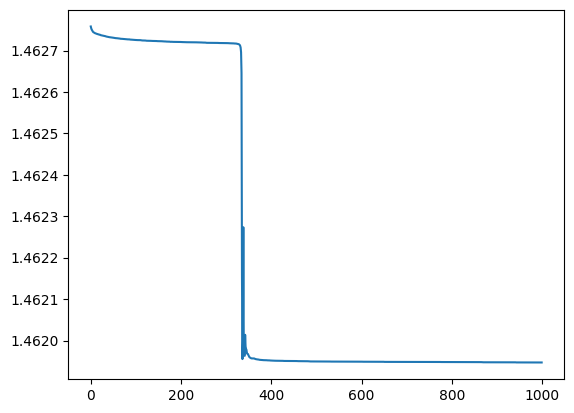

In [122]:
plt.plot(losses)
plt.show()

In [124]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.1780186e-07 4.2356592e-07 9.9998474e-01 4.6215891e-06 7.4967488e-07
 4.8543619e-08 9.9935244e-07 1.0347535e-06 3.2611381e-06 4.0163632e-06]
argmax를 한 후의 output은 2
accuracy는 0.9833333333333333


## 시도 2 
        self.layer1 = nn.Sequential(nn.Linear(64, 512),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(512)
                                  )
        self.layer2 = nn.Sequential(nn.Linear(512, 256),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(256)
                                  )
        self.layer3 = nn.Sequential(nn.Linear(256,128),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(128)
                                  )
        self.layer4 = nn.Sequential(nn.Linear(128,64),
                                  nn.ReLU(),
                                   nn.BatchNorm1d(64))
                                    
        self.layer5 = nn.Sequential(nn.Linear(64, 10),
                                  nn.Softmax()
                                  )

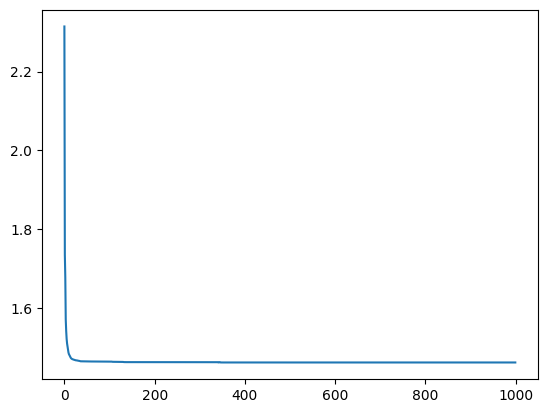

In [221]:
plt.plot(losses)
plt.show()

In [224]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.9809778e-07 2.6678740e-07 9.9999559e-01 2.9670111e-06 4.0406394e-09
 4.7841791e-08 9.8224533e-08 7.2619613e-08 7.1885671e-07 3.1498931e-08]
argmax를 한 후의 output은 2
accuracy는 0.9777777777777777


## 시도 3


        self.layer1 = nn.Sequential(nn.Linear(64, 512),
                                  nn.ReLU()
                                  )
        self.layer2 = nn.Sequential(nn.Linear(512, 256),
                                  nn.ReLU()
                                  )
        self.layer3 = nn.Sequential(nn.Linear(256,128),
                                  nn.ReLU()
                                  )
        self.layer4 = nn.Sequential(nn.Linear(128,64),
                                  nn.ReLU()
                                   )
                                    
        self.layer5 = nn.Sequential(nn.Linear(64, 10),
                                  nn.Softmax()
                                  )

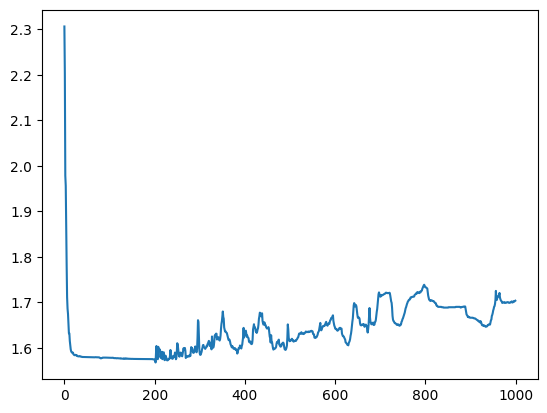

In [232]:
plt.plot(losses)
plt.show()

In [233]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 2
accuracy는 0.7518518518518519


# CNN

- layer 수를 직접 계산해서 넣어야 한다 (이어지는 게 아니라, 공식으로 계산해야한다)
- 맨 마지막은 flatten 시켜서 linear로 보아야 한다.

In [135]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [136]:
trans = transforms.Compose([
    transforms.RandomResizedCrop(size = 28, scale = (0.5, 1.0)), # 중간 기준 일부분만 잘라냄. (여기서는 그냥 정의만 함. )
    transforms.RandomHorizontalFlip(), # 옆으로 뒤집기
    transforms.RandomVerticalFlip(), # 위아래 뒤집기
    transforms.RandomRotation(10), # -10 ~ +10 도 기울기
    transforms.ToTensor() # 텐서로 변환 (이미지는 array, 텐서로 변환)
])

In [193]:
batch_size = 64

train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

In [194]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [195]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [196]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [206]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320,10)
    
    
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)
        x = self.fc(x)
        return F.log_softmax(x)

In [210]:
test_model = Net().to(device)
# test_model(mnist_test.data[0].type(torch.float32).view(-1,28,28))

In [211]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum= 0.5)

In [212]:
def train(epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device) 
        # 앞으로 이거를 통해서 grad, data, grad_fn(backward후 미분)를 계산 및 보겠다
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        
        

In [213]:
def test():
    model.eval() 
    # evaluation 과정에서 사용하지 않을 layer들을 수행하지 않음.
    # 학습할 때만 필요한 Dropout, BatchNorm layer 등을 수행하지 않음.
    test_loss = 0
    correct = 0
    with torch.no_grad():# model안의 Variable들의 gradient 추적 중단 및 업데이트 중단
        for data, target in test_loader:
            data, target = Variable(data, volatile = True).to(device), Variable(target).to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average= False).data
            # nll_loss + log_softmax = Cross entorpy (cross entropy시에는 softmax를 마지막 layer에 사용)
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    

In [214]:
for epoch in range(1, 10):
    train(epoch)
    test()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289888
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.293001
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.262386
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261545
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.248804
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.213537
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.209642
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.180830
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.131850
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.073099
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.979782
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.729370
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.579321
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.359909
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.004479
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.948271
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.751223
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.738187
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.787225
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.686653
Train Epoch: 1 [12800/60000 (

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':



Test set: Average loss: 0.1961, Accuracy: 9434/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.111977
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.216360
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.513448
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.223371
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.120169
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.249799
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.251036
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.256873
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.189647
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.297765
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.236799
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.084871
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.183384
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.191140
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.051463
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.107607
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.046159
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.092471
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.134572
Train Epoch: 2 [12

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.049924
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.146769
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.169081
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.109875
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.111704
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.165090
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.093170
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.047881
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.044623
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.051995
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.239166
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.030570
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.061621
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.072167
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.041003
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.059609
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.120254
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.052565
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.258018
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.041101


Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.137493
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.043665
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.061972
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.139379
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.115079
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.026947
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.016510
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.038457
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.108147
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.202911
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.033911
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.223384
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.105581
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.025809
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.104274
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.088454
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.023274
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.102240
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.050644
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.056152


Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.102540
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.012186
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.077378
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.040685
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.041111
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.131334
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.125073
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.091454
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.076366
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.029372
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.046609
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.043995
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.096769
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.042039
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.096045
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.104326
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.050276
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.088696
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.065488
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.067313


Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.019425

Test set: Average loss: 0.0518, Accuracy: 9832/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.077649
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.026136
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.142856
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.024593
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.057365
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.038108
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.048627
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.133322
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.053331
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.119194
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.069756
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.006736
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.024762
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.118125
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.009372
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.118075
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.033158
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.061124
Train Epoch: 9 [11